In [1]:
from pathlib import Path
import plotly.express as px
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
import numpy as np
import wandb
import torch
from torch import nn
import sys
sys.path.append(str(Path.cwd().parent))
from viz_utils import load_dfiv_model, predict_dfiv_model, load_dfiv_runs, create_combined_df, create_latex_df, convert_to_latex_table, save_latex_str

In [2]:
IMAGE_DIR = Path.cwd() / 'images'

In [3]:
entity, project = "jasmineqy0", "spaceIV-search" 

# Data Size 1600

In [4]:
group = 'dfiv_spaceiv_vanilla_1600'
runs_df = load_dfiv_runs(entity, project, filters={'group' : group})
runs_df = runs_df[runs_df['state'].apply(lambda x: x == 'finished')]
# runs_df
runs_df = runs_df[runs_df['summary'].apply(lambda x: 'min_test_loss' in x)]
print('Number of runs: ', len(runs_df))

Number of runs:  20


In [5]:
test_loss_idx = runs_df['summary'].apply(lambda x: True if 'test loss' in x else False)
test_loss_df = runs_df[test_loss_idx]
print('Number of runs with test loss: ', len(test_loss_df))

size_1600_test_loss = test_loss_df['summary'].apply(lambda x: x['min_test_loss'])

min_idx, min_test_loss = np.argmin(size_1600_test_loss), np.min(size_1600_test_loss)
print(f"min test loss: {min_test_loss}\n")

size_1600_mean_test_loss = np.mean(size_1600_test_loss)
print('mean test loss: ', size_1600_mean_test_loss)

size_1600_std_test_loss = np.std(size_1600_test_loss)
print('std test loss: ', size_1600_std_test_loss)

size_1600_median_test_loss = np.median(size_1600_test_loss)
print('median test loss: ', size_1600_median_test_loss)

Number of runs with test loss:  20
min test loss: 852.3488159179688

mean test loss:  2049.4605865478516
std test loss:  1269.9461630467458
median test loss:  1667.8117065429688


In [6]:
best_run = runs_df.iloc[min_idx]
assert best_run['summary']['min_test_loss'] == min_test_loss, 'min test loss not equal to min test loss in test loss df'
best_run_name, best_run_id = best_run['name'], best_run['id']
print(f'best run name: {best_run_name}, best run id: {best_run_id}')

run_path_size_1600 = '/'.join([entity, project, best_run_id])
print(f'best run path: {run_path_size_1600}')

dfiv_size_1600_model = load_dfiv_model(run_path_size_1600)

best run name: rich-moon-2061, best run id: t0d0b5em
best run path: jasmineqy0/spaceIV-search/t0d0b5em


RuntimeError: Error(s) in loading state_dict for Sequential:
	Unexpected key(s) in state_dict: "4.weight", "4.bias", "6.weight", "6.bias". 
	size mismatch for 0.weight: copying a param with shape torch.Size([57, 20]) from checkpoint, the shape in current model is torch.Size([16, 20]).
	size mismatch for 0.bias: copying a param with shape torch.Size([57]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for 2.weight: copying a param with shape torch.Size([57, 57]) from checkpoint, the shape in current model is torch.Size([1, 16]).
	size mismatch for 2.bias: copying a param with shape torch.Size([57]) from checkpoint, the shape in current model is torch.Size([1]).

# Data Size 3200

In [ ]:
group = 'dfiv_spaceiv_vanilla_3200'
runs_df = load_dfiv_runs(entity, project, filters={'group' : group})
runs_df = runs_df[runs_df['state'].apply(lambda x: x == 'finished')]
# runs_df
runs_df = runs_df[runs_df['summary'].apply(lambda x: 'min_test_loss' in x)]
print('Number of runs: ', len(runs_df))

Number of runs:  20


In [ ]:
test_loss_idx = runs_df['summary'].apply(lambda x: True if 'test loss' in x else False)
test_loss_df = runs_df[test_loss_idx]
print('Number of runs with test loss: ', len(test_loss_df))

size_3200_test_loss = test_loss_df['summary'].apply(lambda x: x['min_test_loss'])

min_idx, min_test_loss = np.argmin(size_3200_test_loss), np.min(size_3200_test_loss)
print(f"min test loss: {min_test_loss}\n")

size_3200_mean_test_loss = np.mean(size_3200_test_loss)
print('mean test loss: ', size_3200_mean_test_loss)

size_3200_std_test_loss = np.std(size_3200_test_loss)
print('std test loss: ', size_3200_std_test_loss)

size_3200_median_test_loss = np.median(size_3200_test_loss)
print('median test loss: ', size_3200_median_test_loss)

Number of runs with test loss:  20
min test loss: 1686.5736083984375

mean test loss:  4859.435687255859
std test loss:  2094.6658880503765
median test loss:  4106.658935546875


In [ ]:
best_df = test_loss_df.iloc[min_idx]['history']
best_df = best_df.dropna(subset=['epoch'])
best_df = best_df.sort_values(by='epoch')
best_df = best_df.groupby('epoch').mean().reset_index()

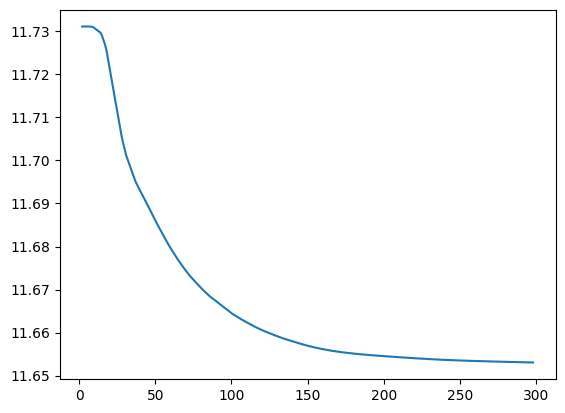

In [ ]:
train_2_loss_idx = best_df[best_df['stage 2 train loss'].notnull()].index
val_2_loss_idx = best_df[best_df['stage 2 val loss'].notnull()].index
test_loss_idx = best_df[best_df['test loss'].notnull()].index

train_2_loss = best_df.loc[train_2_loss_idx]['stage 2 train loss']
train_2_epoch = best_df.loc[train_2_loss_idx]['epoch']
val_2_loss = best_df.loc[val_2_loss_idx]['stage 2 val loss']
val_2_epoch = best_df.loc[val_2_loss_idx]['epoch']
test_loss = best_df.loc[test_loss_idx]['test loss']
test_epoch = best_df.loc[test_loss_idx]['epoch']

plt.plot(train_2_epoch, train_2_loss)

In [ ]:
best_run = runs_df.iloc[min_idx]
assert best_run['summary']['min_test_loss'] == min_test_loss, 'min test loss not equal to min test loss in test loss df'
best_run_name, best_run_id = best_run['name'], best_run['id']
print(f'best run name: {best_run_name}, best run id: {best_run_id}')

run_path_size_3200 = '/'.join([entity, project, best_run_id])
print(f'best run path: {run_path_size_3200}')

dfiv_size_3200_model = load_dfiv_model(run_path_size_3200)

best run name: summer-salad-2026, best run id: oi66m2lu
best run path: jasmineqy0/spaceIV-search/oi66m2lu


# Data Size 6400

In [31]:
group = 'dfiv_spaceiv_vanilla_6400'
runs_df = load_dfiv_runs(entity, project, filters={'group' : group})
runs_df = runs_df[runs_df['state'].apply(lambda x: x == 'finished')]
# runs_df
runs_df = runs_df[runs_df['summary'].apply(lambda x: 'min_test_loss' in x)]
print('Number of runs: ', len(runs_df))

Number of runs:  20


In [33]:
test_loss_idx = runs_df['summary'].apply(lambda x: True if 'test loss' in x else False)
test_loss_df = runs_df[test_loss_idx]
print('Number of runs with test loss: ', len(test_loss_df))

size_6400_test_loss = test_loss_df['summary'].apply(lambda x: x['min_test_loss'])

min_idx, min_test_loss = np.argmin(size_6400_test_loss), np.min(size_6400_test_loss)
print(f"min test loss: {min_test_loss}\n")

size_6400_mean_test_loss = np.mean(size_6400_test_loss)
print('mean test loss: ', size_6400_mean_test_loss)

size_6400_std_test_loss = np.std(size_6400_test_loss)
print('std test loss: ', size_6400_std_test_loss)

size_6400_median_test_loss = np.median(size_6400_test_loss)
print('median test loss: ', size_6400_median_test_loss)

Number of runs with test loss:  20
min test loss: 3349.1435546875

mean test loss:  9730.828564453124
std test loss:  4019.425053160236
median test loss:  8394.35546875


In [ ]:
best_run = runs_df.iloc[min_idx]
assert best_run['summary']['min_test_loss'] == min_test_loss, 'min test loss not equal to min test loss in test loss df'
best_run_name, best_run_id = best_run['name'], best_run['id']
print(f'best run name: {best_run_name}, best run id: {best_run_id}')

run_path_size_1600 = '/'.join([entity, project, best_run_id])
print(f'best run path: {run_path_size_1600}')

dfiv_size_1600_model = load_dfiv_model(run_path_size_1600)

best run name: rich-moon-2061, best run id: t0d0b5em
best run path: jasmineqy0/spaceIV-search/t0d0b5em


## Unidentifiable

## spaceIV

In [37]:
spaceiv_dir = Path('../../spaceIV')
spaceiv_res_root_dir = spaceiv_dir / 'results' / 'comp'
spaceiv_data_root_dir = spaceiv_dir / 'data'
case = 'case:identifiable-iv_num:30'

In [38]:
cases = [case]
dfs = {case: pd.read_csv(spaceiv_res_root_dir / f'{case}.csv') for case in cases}
df_spaceiv = dfs[case]
df_spaceiv['model'] = 'spaceIV'
df_spaceiv

,Unnamed: 0,case,data_size,test_size,mse,sample_dir,model
0,0,case:identifiable-iv_num:30,3200,400,0.001727,a1a3-1,spaceIV
1,1,case:identifiable-iv_num:30,3200,400,0.002294,a1a3-9,spaceIV
2,2,case:identifiable-iv_num:30,3200,400,0.000120,a1a3-3,spaceIV
3,3,case:identifiable-iv_num:30,3200,400,0.000363,a1a3-2,spaceIV
4,4,case:identifiable-iv_num:30,3200,400,0.002536,a1a3-14,spaceIV
5,5,case:identifiable-iv_num:30,3200,400,0.000634,a1a3-6,spaceIV
6,6,case:identifiable-iv_num:30,3200,400,0.009812,a1a3-16,spaceIV
7,7,case:identifiable-iv_num:30,3200,400,0.000988,a1a3-15,spaceIV
8,8,case:identifiable-iv_num:30,3200,400,0.006077,a1a3-5,spaceIV
9,9,case:identifiable-iv_num:30,3200,400,0.002041,a1a3-10,spaceIV


In [39]:
spaceiv_mean_mse = df_spaceiv['mse'].mean()
spaceiv_std_mse = df_spaceiv['mse'].std()
print(f'spaceIV mean mse: {spaceiv_mean_mse}, std mse: {spaceiv_std_mse}', 'median', df_spaceiv['mse'].median())

spaceIV mean mse: 0.003267003353068485, std mse: 0.003429944871225407 median 0.001836368413609


In [16]:
# find best sample
best_sample = df_spaceiv.iloc[df_spaceiv['mse'].idxmin()]
best_sample_name = best_sample['sample_dir']
best_sample_train_size = best_sample['data_size']
best_sample_test_size = best_sample['test_size']
best_sample_train_dir = spaceiv_data_root_dir / case / best_sample_name / f'data_size:{best_sample_train_size}'
best_sample_test_dir = spaceiv_data_root_dir / case / best_sample_name / f'data_size:{best_sample_test_size}'
assert best_sample_train_dir.exists(), f'error: best sample dir {best_sample_train_dir} not exist'
assert best_sample_test_dir.exists(), f'error: best sample dir {best_sample_test_dir} not exist'

# load from best sample
best_beta_hat = np.loadtxt(best_sample_train_dir / 'beta_hat.csv', delimiter=',')
best_beta_star = np.loadtxt(best_sample_train_dir / 'beta_star.csv', delimiter=',')
test_X = np.loadtxt(best_sample_test_dir / 'X.csv', delimiter=',')


In [34]:
num_point = 20000

assert np.array_equal(np.nonzero(best_beta_star),np.nonzero(best_beta_hat)), 'error: non-zero indices not equal'
nonzero_idx = np.nonzero(best_beta_star)[0]

cols_min = np.min(test_X, axis=0)
cols_max = np.max(test_X, axis=0)
cols_samples = np.vstack([np.random.uniform(cols_min[i], cols_max[i], num_point) for i in range(cols_min.shape[0])]).T
col0, col1 = cols_samples[:, nonzero_idx[0]], cols_samples[:, nonzero_idx[1]]

true_structual = cols_samples @ best_beta_star
est_structual = cols_samples @ best_beta_hat

In [36]:
# df = pd.DataFrame(dict(
#     x = np.tile(col0_vals.squeeze(), 2),
#     y = np.tile(col1_vals.squeeze(), 2),
#     z = np.concatenate((est_structual, true_structual)),
#     type = np.array(['estimation'] * num_point + ['truth'] * num_point)
# ))
# fig = px.line_3d(df, x="x", y="y", z='z', color='type', title="estimation") 
# fig.show()

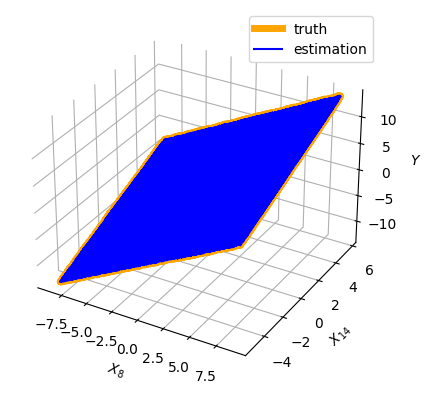

In [44]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

ax.plot(col0, col1, true_structual, 'orange', label='truth', linewidth=5)
ax.plot(col0, col1, est_structual, 'blue', label='estimation')
ax.set_zlabel('$Y$')
ax.set_xlabel(f'$X_8$')
ax.set_ylabel('$X_{14}$')
ax.legend()

# DFIV

## Num IV 20

In [40]:
project, group = 'default', 'dfiv_spaceiv_identifiable_dim_iv_20'
runs_df = load_dfiv_runs(entity, project, filters={'group' : group})
runs_df = runs_df[runs_df['state'].apply(lambda x: x == 'finished')]
# runs_df
runs_df = runs_df[runs_df['summary'].apply(lambda x: 'min_test_loss' in x)]
print('Number of runs: ', len(runs_df))

Number of runs:  20


In [41]:
test_loss_idx = runs_df['summary'].apply(lambda x: True if 'test loss' in x else False)
test_loss_df = runs_df[test_loss_idx]
print('Number of runs with test loss: ', len(test_loss_df))

div_20_test_loss = test_loss_df['summary'].apply(lambda x: x['min_test_loss'])

min_idx, min_test_loss = np.argmin(div_20_test_loss), np.min(div_20_test_loss)
print(f"min test loss: {min_test_loss}\n")

div_20_mean_test_loss = np.mean(div_20_test_loss)
print('mean test loss: ', div_20_mean_test_loss)

div_20_std_test_loss = np.std(div_20_test_loss)
print('std test loss: ', div_20_std_test_loss)

div_20_median_test_loss = np.median(div_20_test_loss)
print('median test loss: ', div_20_median_test_loss)

Number of runs with test loss:  20
min test loss: 2880.83984375

mean test loss:  5967.03955078125
std test loss:  2295.2417059229665
median test loss:  5459.358154296875


In [42]:
best_run = runs_df.iloc[min_idx]
assert best_run['summary']['min_test_loss'] == min_test_loss, 'min test loss not equal to min test loss in test loss df'
best_run_name, best_run_id = best_run['name'], best_run['id']
print(f'best run name: {best_run_name}, best run id: {best_run_id}')

run_path_div_20 = '/'.join([entity, project, best_run_id])
print(f'best run path: {run_path_div_20}')

dfiv_div_20_model = load_dfiv_model(run_path_div_20)

best run name: dauntless-lion-19, best run id: 5av5u6jj
best run path: jasmineqy0/default/5av5u6jj


## Num IV 30

In [43]:
project, group = 'default', 'dfiv_spaceiv_identifiable_dim_iv_30'
runs_df = load_dfiv_runs(entity, project, filters={'group' : group})
runs_df = runs_df[runs_df['state'].apply(lambda x: x == 'finished')]
# runs_df
runs_df = runs_df[runs_df['summary'].apply(lambda x: 'min_test_loss' in x)]
print('Number of runs: ', len(runs_df))

Number of runs:  20


In [44]:
test_loss_idx = runs_df['summary'].apply(lambda x: True if 'test loss' in x else False)
test_loss_df = runs_df[test_loss_idx]
print('Number of runs with test loss: ', len(test_loss_df))

div_30_test_loss = test_loss_df['summary'].apply(lambda x: x['min_test_loss'])

min_idx, min_test_loss = np.argmin(div_30_test_loss), np.min(div_30_test_loss)
print(f"min test loss: {min_test_loss}\n")

div_30_mean_test_loss = np.mean(div_30_test_loss)
print('mean test loss: ', div_30_mean_test_loss)

div_30_std_test_loss = np.std(div_30_test_loss)
print('std test loss: ', div_30_std_test_loss)

div_30_median_test_loss = np.median(div_30_test_loss)
print('median test loss: ', div_30_median_test_loss)

Number of runs with test loss:  20
min test loss: 3058.67919921875

mean test loss:  6902.294213867188
std test loss:  2514.6034014968086
median test loss:  7198.861083984375


In [87]:
best_run = runs_df.iloc[min_idx]
assert best_run['summary']['min_test_loss'] == min_test_loss, 'min test loss not equal to min test loss in test loss df'
best_run_name, best_run_id = best_run['name'], best_run['id']
print(f'best run name: {best_run_name}, best run id: {best_run_id}')

run_path_div_30 = '/'.join([entity, project, best_run_id])
print(f'best run path: {run_path_div_30}')

dfiv_div_30_model = load_dfiv_model(run_path_div_30)

best run name: confused-field-39, best run id: vo59heqy
best run path: jasmineqy0/default/vo59heqy


## Visualization

In [40]:
run_path = 'jasmineqy0/spaceIV-final/3hvmbt5r'

In [38]:
num_point = 20000

assert np.array_equal(np.nonzero(best_beta_star),np.nonzero(best_beta_hat)), 'error: non-zero indices not equal'
nonzero_idx = np.nonzero(best_beta_star)[0]

cols_min = np.min(test_X, axis=0)
cols_max = np.max(test_X, axis=0)
cols_samples = np.vstack([np.random.uniform(cols_min[i], cols_max[i], num_point) for i in range(cols_min.shape[0])]).T
col0, col1 = cols_samples[:, nonzero_idx[0]], cols_samples[:, nonzero_idx[1]]

true_structual = cols_samples @ best_beta_star
est_structual = cols_samples @ best_beta_hat

In [41]:
# load model
dfiv_model = load_dfiv_model(run_path)

In [49]:
# predict
test_X = np.tile(cols_mean, (num_point, 1))
test_X[:, nonzero_idx] = cols_samples[:, nonzero_idx]
# dfiv_pred = mdl.predict_t(treatment=test_X_tensor, covariate=None).detach().numpy()
dfiv_pred = predict_dfiv_model(dfiv_model, cols_samples, None)
dfiv_pred = dfiv_pred.squeeze()

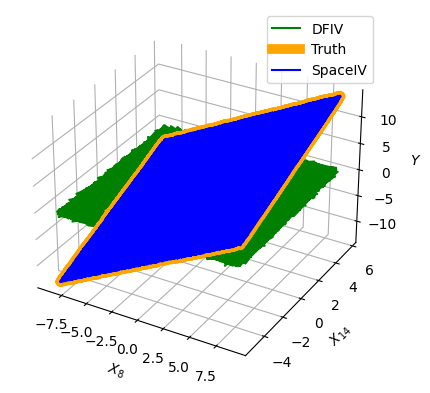

In [61]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

ax.plot(col0, col1, dfiv_pred, 'green', label='DFIV')
ax.plot(col0, col1, true_structual, 'orange', label='Truth', linewidth=7)
ax.plot(col0, col1, est_structual, 'blue', label='SpaceIV')
ax.set_zlabel('$Y$')
ax.set_xlabel('$X_8$')
ax.set_ylabel('$X_{14}$')
ax.legend()
plt.savefig(IMAGE_DIR / 'data:spaceiv_alg:spaceiv_and_dfiv.pdf')

## Loss Visualization

In [14]:
from viz_utils import load_dfiv_runs

In [15]:
wandb_data_dir = Path.cwd() / 'data'

train_loss = pd.read_csv(wandb_data_dir / 'train_loss.csv')['summer-salad-2026 - stage 2 train loss'][:100]
test_loss = pd.read_csv(wandb_data_dir / 'test_loss.csv')['summer-salad-2026 - test loss'][:100]
val_loss = pd.read_csv(wandb_data_dir / 'val_loss.csv')['summer-salad-2026 - stage 2 val loss'][:100]
epoch = pd.read_csv(wandb_data_dir / 'val_loss.csv')['epoch'][:100]

In [16]:
# val_loss[1:].shape
# val_loss[:1].shape

In [9]:
shifted_vector = np.concatenate((val_loss[1:], val_loss[:1]))
shifted_vector.shape

(100,)

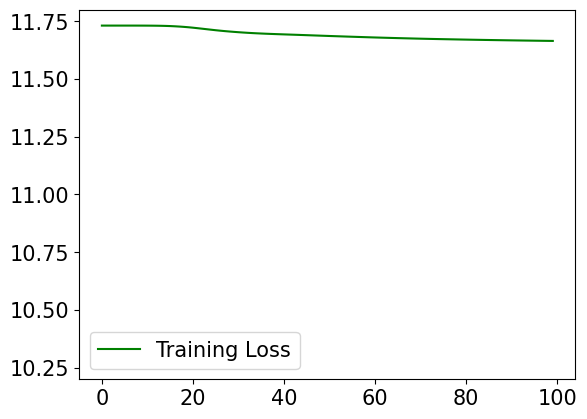

In [19]:
plt.plot(epoch, train_loss, '-g', label='Training Loss')
# plt.plot(epoch, val_loss, '-b', label='Validation Loss')
# plt.plot(epoch, test_loss, '-r', label='test loss')
plt.legend()
plt.ylim([10.2,11.8])
plt.savefig('images/train_val_loss.pdf')
plt.rcParams.update({'font.size': 15})

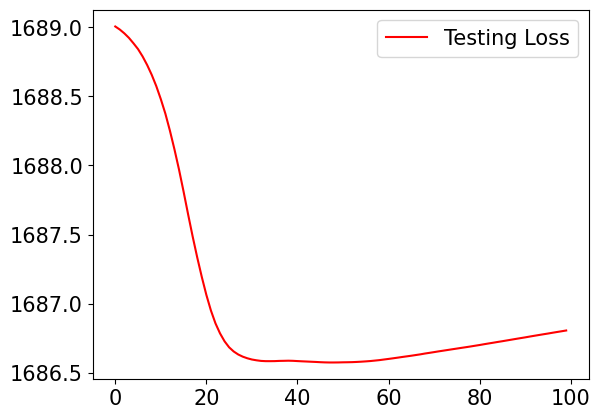

In [20]:
plt.plot(epoch, test_loss, '-r', label='Testing Loss')
plt.legend()
plt.savefig('images/test_loss.pdf')
plt.rcParams.update({'font.size': 15})